In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


warnings.filterwarnings('ignore')
df = pd.read_csv("MakroDashboard\data\ML data\Quarterly_wide2.csv")  # Make sure it has 15 columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Ricks\AppData\Local\Temp\ipykernel_10768\2372183292.py:16: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("MakroDashboard\data\ML data\Quarterly_wide2.csv")  # Make sure it has 15 columns


In [3]:
# Step 1: Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')

# Step 2: Select numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Step 3: Add time column back
df_final = pd.concat([df_numeric, df[['time']]], axis=1)

# Step 4: Fill NaNs
df_final = df_final.dropna()

# Step 5: Identify target columns (Finland columns)
finland_columns = [col for col in df_final.columns if 'Finland' in col]

In [4]:
# Step 6: Create lagged features for all numeric columns (excluding 'time')
def create_lag_features(df, columns, lags=3):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Create lag features
lagged_df = create_lag_features(df_final.copy(), df_numeric.columns, lags=3)

# Step 7: Create future target (1 step ahead)
horizon = 1  # You can change this to 3 for 3-month ahead prediction
for col in finland_columns:
    lagged_df[f'{col}_target'] = lagged_df[col].shift(-horizon)

# Step 8: Drop original (non-lagged) features + rows with NaN
lagged_df = lagged_df.drop(columns=finland_columns + ['time'])  # keep only lags + targets
lagged_df = lagged_df.dropna()

# Step 9: Train/test split
train_size = int(len(lagged_df) * 0.8)
train_data = lagged_df.iloc[:train_size]
test_data = lagged_df.iloc[train_size:]

# Step 10: Features (X) and Targets (y)
target_columns = [col for col in lagged_df.columns if col.endswith('_target')]

X_train = train_data.drop(columns=target_columns)
y_train = train_data[target_columns]

X_test = test_data.drop(columns=target_columns)
y_test = test_data[target_columns]



In [7]:
# === CONFIG ===
selected_model = 'xgb'  # 'rf' or 'xgb'

# Define base model and param grid
if selected_model == 'xgb':
    base_model_class = XGBRegressor
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 4],
        'model__learning_rate': [0.05, 0.1]
    }
elif selected_model == 'rf':
    base_model_class = RandomForestRegressor
    param_grid = {
        'model__n_estimators': [100, 200, 300]
    }
else:
    raise ValueError("Choose either 'xgb' or 'rf'.")

# === LOOP OVER TARGETS ===
all_best_models = []
all_results = []

for i, target in enumerate(y_train.columns):
    print(f" Tuning model for target: {target}")

    y_target = y_train[target]

    model = base_model_class()
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid.fit(X_train, y_target)

    best_model = grid.best_estimator_
    all_best_models.append(best_model)

    all_results.append({
        'target': target,
        'best_params': grid.best_params_,
        'best_mse': -grid.best_score_
    })

# Create MultiOutputRegressor from the tuned models
multi_model = MultiOutputRegressor(estimator=None)
multi_model.estimators_ = [model.named_steps['model'] for model in all_best_models]
multi_model._fit_estimators = all_best_models

# Store results as DataFrame
results_df = pd.DataFrame(all_results)
print("\n Per-target tuning results:")
print(results_df)

 Tuning model for target: Current account_Finland_target
 Tuning model for target: Direct investment_Finland_target
 Tuning model for target: Employees Compensation_Finland_target
 Tuning model for target: Totlat employment_Finland_target
 Tuning model for target: Final consumption expenditure households_Finland_target
 Tuning model for target: Change in GDP_Finland_target
 Tuning model for target: Gross fixed capital formation_Finland_target
 Tuning model for target: Government debt to gdp_Finland_target
 Tuning model for target: Government expenditure_Finland_target
 Tuning model for target: Change in Housing prices_Finland_target
 Tuning model for target: Labour productivity_Finland_target
 Tuning model for target: Net international investment_Finland_target
 Tuning model for target: Nominal unit labour cost_Finland_target

 Per-target tuning results:
                                               target  \
0                      Current account_Finland_target   
1                  

In [8]:
# Print the full results with expanded columns
print("\n📊 Full tuning results per target:\n")
pd.set_option('display.max_colwidth', None)  # Show full parameter dict
print(results_df.to_string(index=False))


📊 Full tuning results per target:

                                                 target                                                                       best_params     best_mse
                         Current account_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 100} 7.960171e+00
                       Direct investment_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100} 1.348422e+08
                  Employees Compensation_Finland_target  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200} 1.557386e+06
                       Totlat employment_Finland_target  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200} 6.710717e+03
Final consumption expenditure households_Finland_target  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100} 1.458892e+06
                           Change in GDP_Finland_target {'

In [9]:
chosen_model_type = selected_model

# Store final models per target variable
Optimized_models = {}

# Loop through each target variable and train best model with pipeline
for _, row in results_df.iterrows():
    target = row['target']
    best_params = row['best_params'] or {}

    # Clean parameter names in case they are prefixed like "xgb__" or "rf__"
    cleaned_params = {
        key.split('__')[-1]: value for key, value in best_params.items()
    }

    # Select model type
    if chosen_model_type == "xgb":
        model = XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist',
            n_jobs=-1,
            **cleaned_params
        )
        model_name = 'xgb'

    elif chosen_model_type == "rf":
        model = RandomForestRegressor(
            n_jobs=-1,
            random_state=42,
            **cleaned_params
        )
        model_name = 'rf'

    else:
        raise ValueError("Unsupported model type. Choose 'xgb' or 'rf'.")

    # Build pipeline with scaler and model
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        (model_name, model)
    ])

    # Fit pipeline to current target
    pipe.fit(X_train, y_train[target])

    # Save the pipeline
    Optimized_models[target] = pipe

print(f"✅ Trained {chosen_model_type.upper()} pipelines with best parameters for each target.")

✅ Trained XGB pipelines with best parameters for each target.


In [10]:
r2_per_target = []

# Ensure X_test has the same features as X_train
X_test = X_test[X_train.columns]

# Evaluate each pipeline (XGB + scaler) on its target
for target in y_test.columns:
    model = Optimized_models[target]
    y_true = y_test[target]
    y_pred = model.predict(X_test)

    r2 = r2_score(y_true, y_pred)
    r2_per_target.append(r2)

    print(f"Target: {target}")
    print(f"  R²: {r2:.4f}")
    print("-" * 30)

# Average R² across all targets
avg_r2 = sum(r2_per_target) / len(r2_per_target)
print("📊 Average R² across all targets:", round(avg_r2, 4))

Target: Current account_Finland_target
  R²: -0.4675
------------------------------
Target: Direct investment_Finland_target
  R²: -7.4489
------------------------------
Target: Employees Compensation_Finland_target
  R²: -10.1808
------------------------------
Target: Totlat employment_Finland_target
  R²: -5.5612
------------------------------
Target: Final consumption expenditure households_Finland_target
  R²: -2.6579
------------------------------
Target: Change in GDP_Finland_target
  R²: -72.3991
------------------------------
Target: Gross fixed capital formation_Finland_target
  R²: 0.0097
------------------------------
Target: Government debt to gdp_Finland_target
  R²: 0.0961
------------------------------
Target: Government expenditure_Finland_target
  R²: -2.8876
------------------------------
Target: Change in Housing prices_Finland_target
  R²: -0.5095
------------------------------
Target: Labour productivity_Finland_target
  R²: -0.8599
------------------------------
T

In [11]:
n_steps = 1  # number of months ahead to forecast
future_forecasts = []

# Start with the most recent input
current_input = X_test.iloc[[-1]].copy()

# Get the feature names from X_train
feature_names = X_train.columns

# Loop through the steps to forecast
for step in range(n_steps):
    # Ensure the current_input contains the correct features
    current_input = current_input[feature_names]
    
    # Predict the next step
    prediction = multi_model.predict(current_input)[0]
    future_forecasts.append(prediction)

    # Shift lag features forward (lag3 -> lag2, lag2 -> lag1, lag1 -> prediction)
    new_input = current_input.copy()
    for i, col in enumerate(y_test.columns):
        try:
            # Shift lags: lag3 -> lag2, lag2 -> lag1
            for lag in range(3, 1, -1):
                new_input[f'{col}_lag{lag}'] = new_input.get(f'{col}_lag{lag-1}', np.nan)
            # Set lag1 to the current prediction for the variable
            new_input[f'{col}_lag1'] = prediction[i]
        except KeyError as e:
            print(f"Skipping column due to KeyError: {e}")

    # Update the input for the next step (if forecasting more than 1 step ahead)
    current_input = new_input.copy()

# Convert forecast list to DataFrame
future_forecast_df = pd.DataFrame(future_forecasts, columns=y_test.columns)

# Print the forecasted values for the next n_steps
print("Forecasts for the next", n_steps, "months:")
print(future_forecast_df)


Forecasts for the next 1 months:
   Current account_Finland_target  Direct investment_Finland_target  \
0                        1.630539                      177891.46875   

   Employees Compensation_Finland_target  Totlat employment_Finland_target  \
0                           29781.642578                        2633.14917   

   Final consumption expenditure households_Finland_target  \
0                                             32135.921875   

   Change in GDP_Finland_target  Gross fixed capital formation_Finland_target  \
0                       2.14422                                  16336.205078   

   Government debt to gdp_Finland_target  \
0                              73.704987   

   Government expenditure_Finland_target  \
0                           16316.996094   

   Change in Housing prices_Finland_target  \
0                                 0.357382   

   Labour productivity_Finland_target  \
0                             0.70638   

   Net international inve

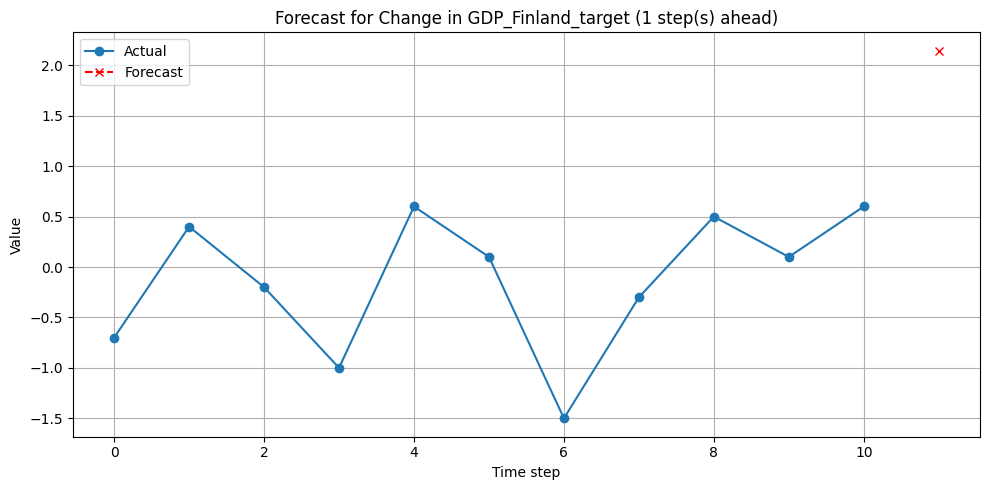

In [13]:
# Choose one variable to plot, e.g., the first one
target_column = y_test.columns[5]

# Combine last few actual values with the forecast
recent_actuals = y_test[target_column].tail(12).reset_index(drop=True)
forecast_values = pd.Series(future_forecast_df[target_column].values, index=range(len(recent_actuals), len(recent_actuals) + n_steps))

plt.figure(figsize=(10, 5))
plt.plot(recent_actuals, label="Actual", marker='o')
plt.plot(forecast_values, label="Forecast", marker='x', linestyle='--', color='red')
plt.title(f"Forecast for {target_column} ({n_steps} step(s) ahead)")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_sorted = df.sort_values(by='time')
df_sorted2 = df_sorted[['time'] + finland_columns]
df_sorted2

,time,Current account_Finland,Direct investment_Finland,Employees Compensation_Finland,Totlat employment_Finland,Final consumption expenditure households_Finland,Change in GDP_Finland,Gross fixed capital formation_Finland,Government debt to gdp_Finland,Government expenditure_Finland,Change in Housing prices_Finland,Labour productivity_Finland,Net international investment_Finland,Nominal unit labour cost_Finland
80,1995-01-01,2.6,NaN,10896,1991.7,12073,-0.8,4266.0,NaN,5240.1,NaN,3.1,NaN,0.6
81,1995-04-01,3.7,NaN,11869,2092.5,12749,2.7,4811.5,NaN,5557.0,NaN,3.8,NaN,-0.2
82,1995-07-01,3.5,NaN,12326,2116.1,12374,-0.4,4988.1,NaN,5827.9,NaN,1.6,NaN,3.8
83,1995-10-01,5.9,NaN,12266,2034.5,13019,0.1,5749.4,NaN,5863.3,NaN,0.4,NaN,2.5
84,1996-01-01,1.6,NaN,11862,2012.9,12254,1.8,4682.2,NaN,5513.0,NaN,3.2,NaN,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-10-01,1.8,191134.0,32080,2724.0,36110,-0.3,16378.0,77.3,18851.0,-1.0,-1.2,12.8,3.4
76,2024-01-01,-1.5,189895.0,32897,2698.2,34122,0.5,14191.0,78.1,17113.0,-1.3,-1.7,19.7,2.0
77,2024-04-01,-2.3,189522.0,33886,2801.7,36196,0.1,14551.0,80.1,18442.0,0.2,0.4,18.2,-0.2
78,2024-07-01,3.0,193770.0,33964,2799.8,36140,0.6,15004.0,81.5,17397.0,-0.7,1.3,21.0,-1.1


In [32]:
df

,time,Current account_Denmark,Current account_Germany,Current account_Spain,Current account_France,Current account_Italy,Current account_Netherlands,Current account_Finland,Current account_Sweden,Direct investment_Denmark,...,Net international investment_Finland,Net international investment_Sweden,Nominal unit labour cost_Denmark,Nominal unit labour cost_Germany,Nominal unit labour cost_Spain,Nominal unit labour cost_France,Nominal unit labour cost_Italy,Nominal unit labour cost_Netherlands,Nominal unit labour cost_Finland,Nominal unit labour cost_Sweden
0,2005-01-01,1.5,4.8,-8.7,0.5,-1.8,8.8,4.1,6.0,714258.0,...,-9.0,-23.5,4.0,0.7,2.8,1.9,3.3,0.0,0.2,1.5
1,2005-04-01,4.7,4.5,-6.7,-0.2,-1.0,6.8,-2.8,5.9,748710.0,...,-15.8,-22.2,1.3,-1.1,3.2,1.2,1.2,-0.3,1.5,-0.9
2,2005-07-01,4.9,3.6,-6.4,0.9,0.2,6.0,5.2,7.1,784681.0,...,-12.1,-20.8,0.8,-1.4,3.2,1.8,0.1,-0.4,3.1,-0.1
3,2005-10-01,4.9,5.7,-7.0,-0.7,-0.9,6.6,5.7,5.2,808470.0,...,-14.0,-17.2,3.1,-1.1,3.5,2.6,4.1,-0.3,3.5,1.5
4,2006-01-01,2.4,5.0,-10.1,0.4,-3.2,11.6,4.1,9.6,836729.0,...,-24.9,-20.4,0.6,-3.2,3.4,0.4,2.0,-1.4,1.4,-0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2003-10-01,NaN,3.5,-3.7,1.1,-0.2,7.4,6.2,5.5,NaN,...,-62.5,-17.2,NaN,0.6,2.9,1.6,3.3,2.5,0.4,-0.3
116,2004-01-01,NaN,4.4,-6.3,1.3,-0.9,7.9,6.0,5.9,NaN,...,-28.8,-18.5,NaN,-0.4,3.9,1.4,3.2,0.3,-0.4,0.1
117,2004-04-01,NaN,4.8,-5.1,0.2,-1.0,6.5,1.1,6.5,NaN,...,-14.5,-19.9,NaN,-0.6,3.2,0.1,3.1,0.6,-0.4,-0.8
118,2004-07-01,NaN,3.0,-5.0,1.0,1.3,6.2,6.3,6.3,NaN,...,-10.0,-19.5,NaN,0.0,2.8,0.6,-0.2,-0.8,1.6,-0.5
